# Auto-encoders for Document Denoising

## About Autoencoders
An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name.

![](https://osclasspoint.com/kaggle/autoencoder.png)

In [76]:
!pip install pandas matplotlib tensorflow scikit-learn opencv-python numpy augraphy huggingface_hub

 

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.1 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
Using cached PyYAML-6.0.2-cp310-cp310-macosx_11_0_arm64.whl (171 kB)
Using cached filelock-3.16.1-py3-none-any.whl (16 kB)


# Before setup everything, lets try to generate

# if mac

In [ ]:
!pip install tensorflow-metal tensorflow-macos

## Import libraries and data
First load libraries we need for our work. We need multiple libraries to be able to unzip files, work with directories, sklearn, tensorflow...

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2 # import the l2 regularizer from keras.regularizers


%matplotlib inline

In [38]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List available physical devices
print("Available devices:", tf.config.list_physical_devices())

Num GPUs Available:  1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [93]:
# # special need for Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/ColabNotebooks/DocDenoise")
# !ls

As we have data zipped, we will have to work in `./data/` directory to unzip images here.

In [39]:
# path to zipped & working directories
path_zip = 'zip/'
path = 'data/'

In [80]:
from huggingface_hub import hf_hub_download
#https://huggingface.co/datasets/manubaun/receipt/resolve/main/Archiv.zip
# https://huggingface.co/docs/huggingface_hub/guides/download
filepath  = hf_hub_download(repo_id="manubaun/receipt", filename="Archiv.zip", repo_type="dataset")


'/Users/manuelbaun/.cache/huggingface/hub/datasets--manubaun--receipt/snapshots/9e21d2874a3af827b43e1744576b12db26b7fd7a/Archiv.zip'

In [81]:
filepath='/Users/manuelbaun/.cache/huggingface/hub/datasets--manubaun--receipt/snapshots/9e21d2874a3af827b43e1744576b12db26b7fd7a/Archiv.zip'

In [82]:
# unzip files first to working directory
#with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
#    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
#with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
#    zip_ref.extractall(path)
    
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(path)

For later use, we will store image names into list, so we can draw them simply.

In [5]:
# store image names in list for later use
train_img = sorted(os.listdir( path+'train/'))
train_cleaned_img = sorted(os.listdir( path+'train_cleaned/'))
test_img = sorted(os.listdir(path+'test/'))

In [6]:
len(train_img),len(train_cleaned_img),len(test_img)

(169, 169, 186)

## Data preparation
Next step is to define function to process images and then store this images in list. As there is not as many data, we do not need to work in batches.

In [7]:
IMG_WIDTH = 400
IMG_HEIGHT = 400

# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
    
    return img

Reshape images and put them into list.

In [8]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in train_img:
    train.append(process_image(path+"train/" + f))

for f in train_cleaned_img:
    train_cleaned.append(process_image(path+'train_cleaned/' + f))
    
for f in test_img:
    test.append(process_image(path + '../data/test/' + f))


## Exploratory data analysis
Not too much to look there, but just quickly look on train images and their cleaned version. This is what we put into model to learn how to clean noise from background.

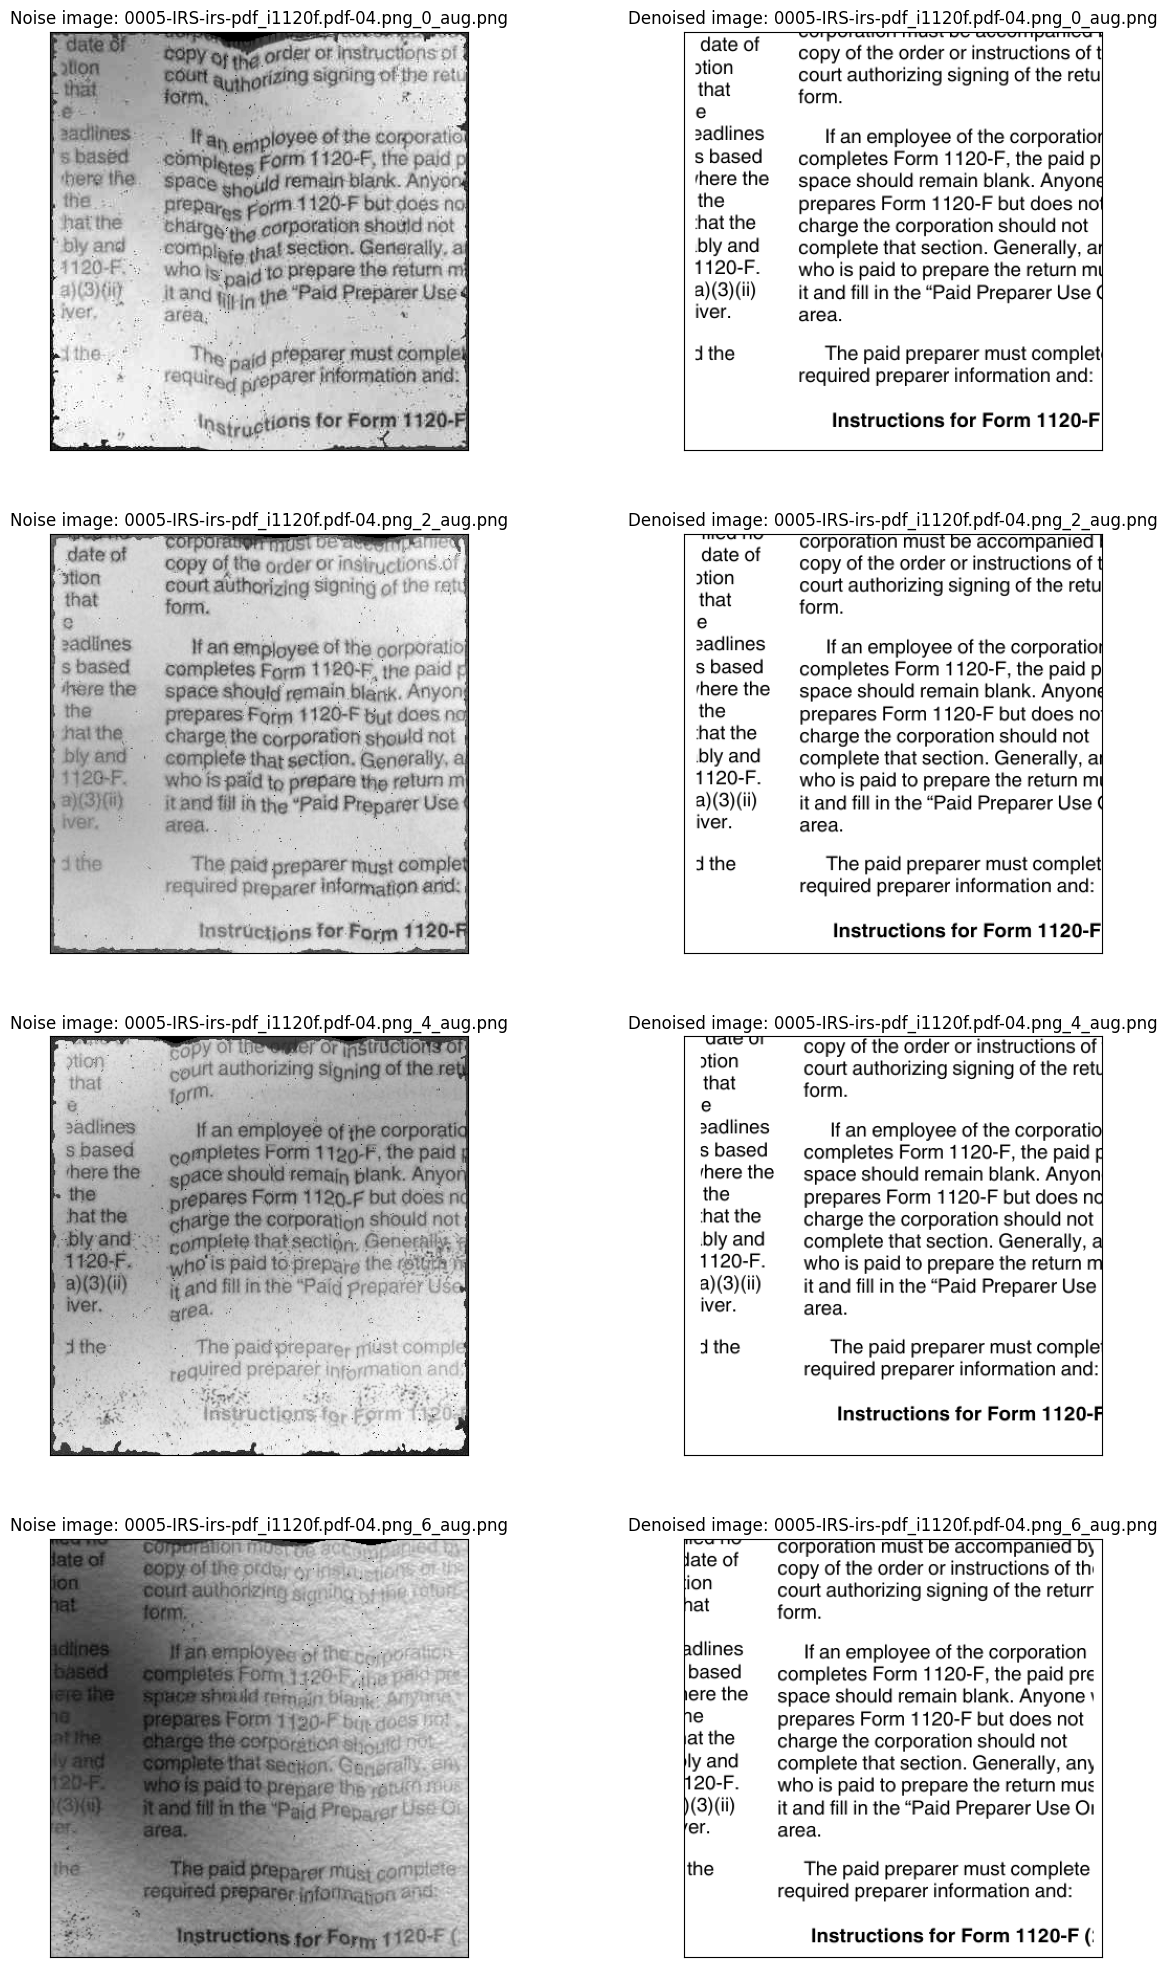

In [9]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

## Split data
In this step we convert lists to numpy arrays and split dataset into train and validation in ration 85% train, 15% test.

In [10]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

## Modeling
It's nice to look at model summary how it works in terms of layer sizes: 420x540 -> 210x270 --> 210x270 -> 420x540

Adam as optimizer is used (as it worked best out of other optimizers), loss is based on mean squared error and we are looking on mean absolute error as well.

## Updated Model Version via Chatgpt

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Activation, add, concatenate
from tensorflow.keras.models import Model

def model():

    input_img = Input(shape=(400, 400, 1))

    # Encoder with batch normalization, dropout, and increased depth
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    c1 = x  # Skip connection
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    c2 = x  # Skip connection
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    c3 = x  # Skip connection
    x = MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # Decoder with skip connections and upsampling
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, c3])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, c2])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, c1])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # Output layer
    decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Compile the model
    model = Model(inputs=input_img, outputs=decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    return model


### Train model
We will run 80 epochs having early stopping set to 10 (if val loss does not drop in 10 epochs, it will stop).

Let's store history of model as well, so we can plot loss (rmse) and mae.

In [13]:
model = model()
model.summary()

2024-09-29 23:22:13.440810: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-29 23:22:13.440840: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-09-29 23:22:13.440846: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-09-29 23:22:13.440913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-29 23:22:13.441173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 400, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 400, 400, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 400, 400, 64)         0         ['batch_normalization[0][0

In [21]:
import tensorflow as tf

class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_dir):
        super(SaveModelCallback, self).__init__()
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        # Save the model at the end of each epoch
        model_path = f"{self.save_dir}/model_epoch_{epoch + 1}.weights.h5"
        self.model.save(model_path)
        print(f"Model saved to {model_path}")
        
# Define your save directory
save_directory = 'checkpoints/autoencoders'

# Create the callback
save_model_callback = SaveModelCallback(save_dir=save_directory)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

#callback = EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, Y_train, 
                    validation_data = (X_val, Y_val), 
                    epochs=100, 
                    batch_size=20, 
                    verbose=1, 
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[early_stopping,lr_scheduler, save_model_callback])



Epoch 1/100
8/8 [==============================] - 40s 5s/step - loss: 0.0237 - val_loss: 0.0411 - lr: 3.0000e-04
Epoch 2/100


/Users/manuelbaun/miniconda3/envs/kerasOCR/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 38s 5s/step - loss: 0.0234 - val_loss: 0.0415 - lr: 3.0000e-04
Epoch 3/100
8/8 [==============================] - 37s 5s/step - loss: 0.0230 - val_loss: 0.0418 - lr: 3.0000e-04
Epoch 4/100
8/8 [==============================] - 38s 5s/step - loss: 0.0226 - val_loss: 0.0423 - lr: 3.0000e-04
Epoch 5/100
8/8 [==============================] - 38s 5s/step - loss: 0.0222 - val_loss: 0.0428 - lr: 3.0000e-04
Epoch 6/100
8/8 [==============================] - 39s 5s/step - loss: 0.0220 - val_loss: 0.0431 - lr: 3.0000e-04
Epoch 7/100
5/8 [=================>............] - ETA: 15s - loss: 0.0218

KeyboardInterrupt: 

## Save model

save the model

In [23]:
model.save_weights('./checkpoints/autoencoders/model_new_checkpoint_1.weights.h5')


In [33]:
# Restore the weights
model.load_weights('./checkpoints/autoencoders/model_epoch_1.weights.h5')

KeyError: "Unable to open object (object 'vars' doesn't exist)"

### Plot error evolution on epochs
You may notice jump in error after approx. 5 epoch that is pretty important, but enought epochs flatten this to almost 0.

In [24]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
# plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

KeyError: 'mae'

## Evaluation
In this step we will "predict", or better say clean test images and check how well model works.

In [25]:
# predict/clean test images
Y_test = model.predict(X_test[:4])

1/1 [==============================] - 0s 302ms/step


Now compare noisy (left) and denoised test images (right). Our model has done great job with denoising!

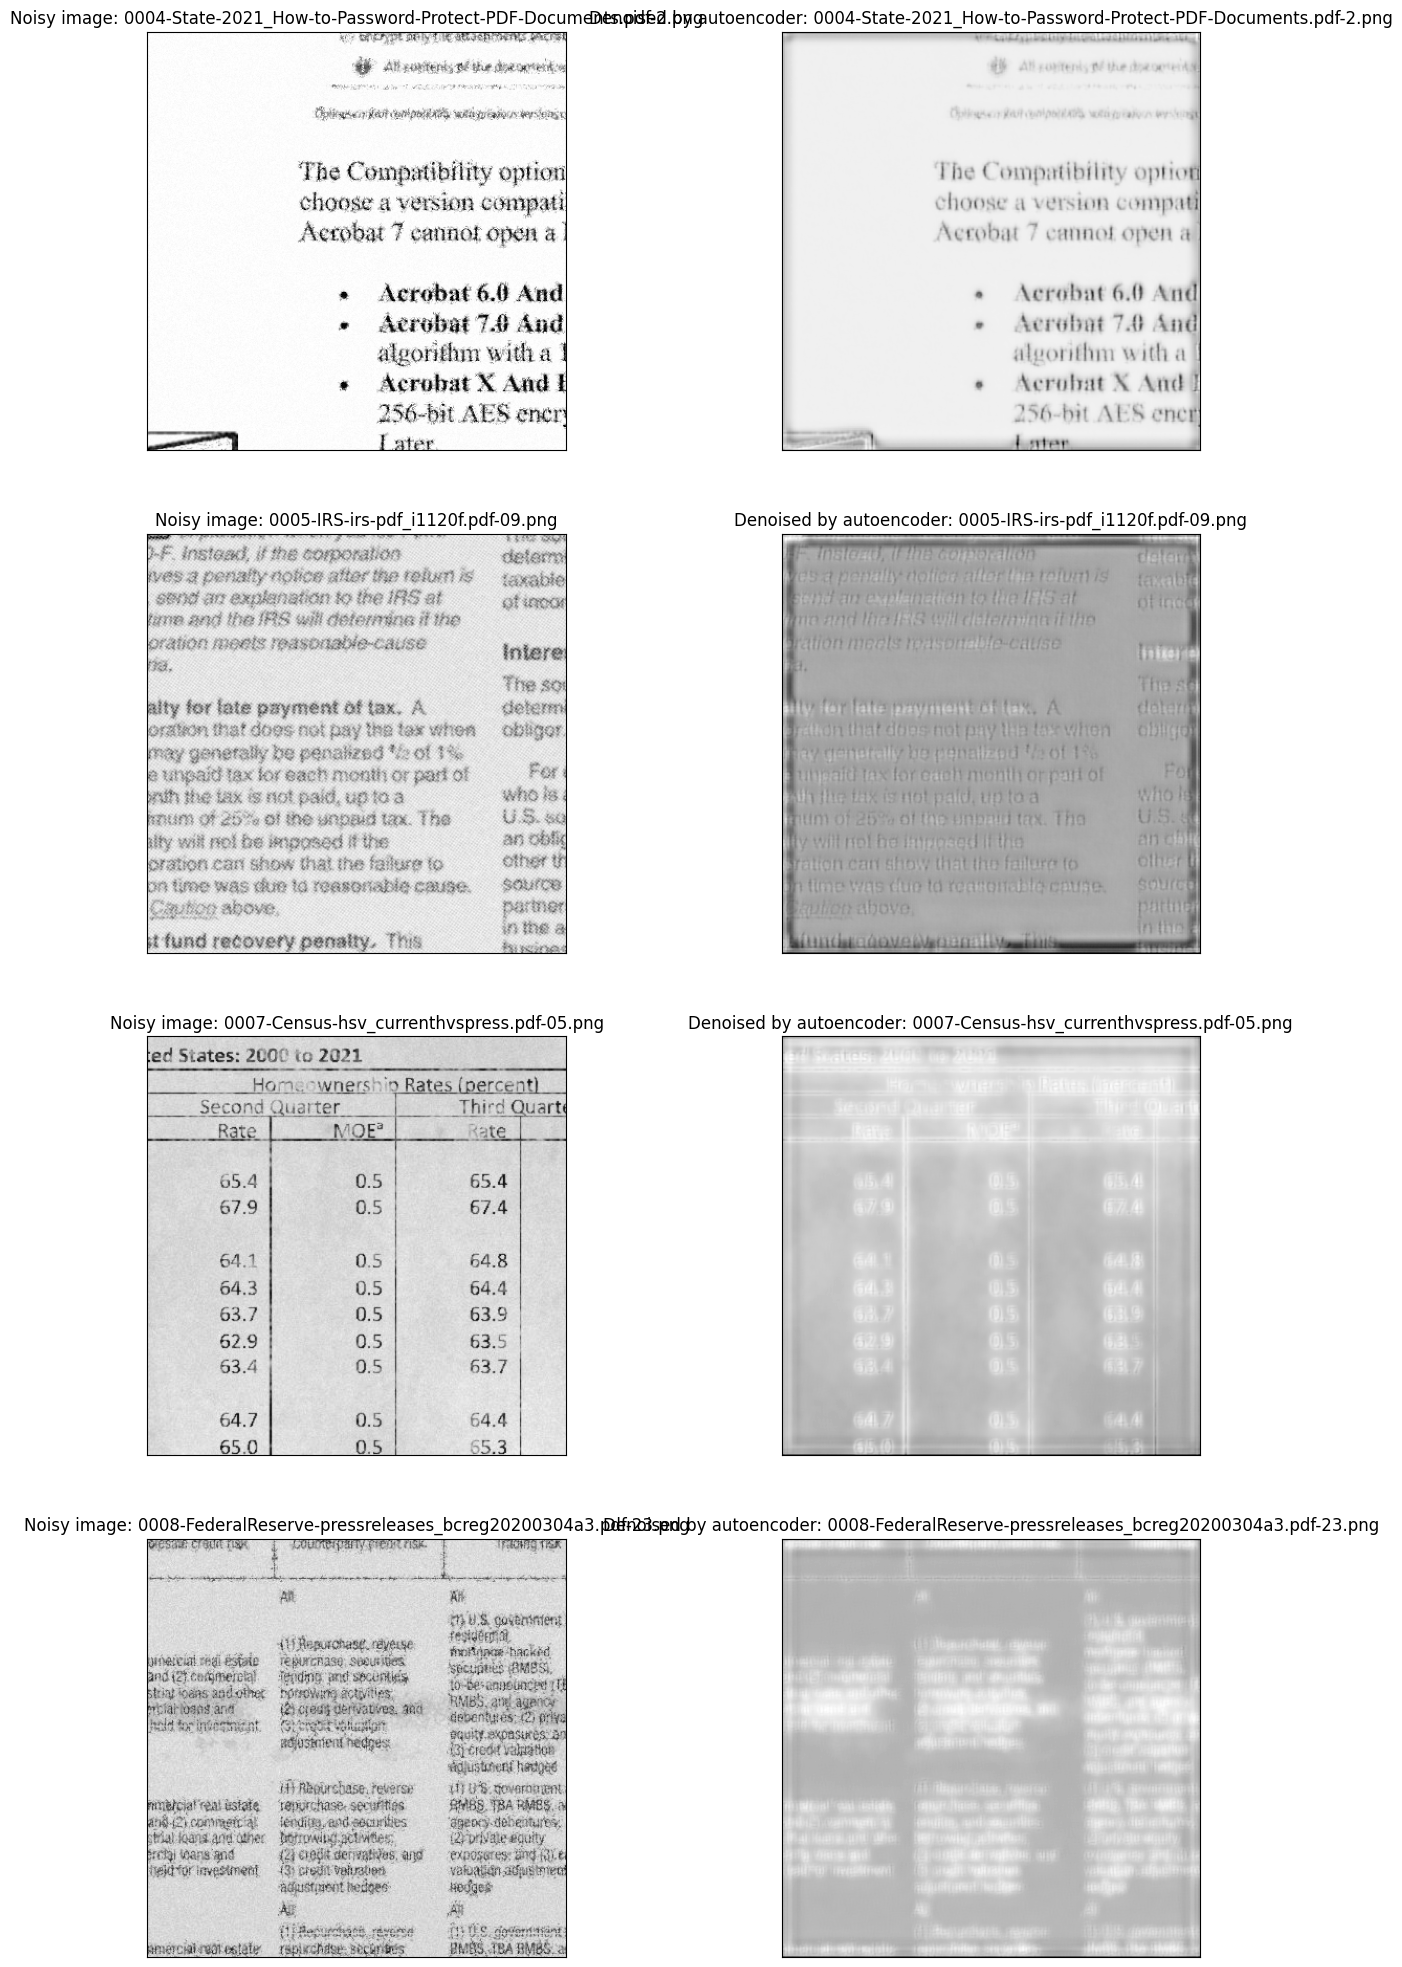

In [29]:
plt.figure(figsize=(15,25))

for i in range(0,8,2):
  index = int(i/2)
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_test[index][:,:,0], cmap='gray')
  plt.title('Noisy image: {}'.format(test_img[index]))
  
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(Y_test[index][:,:,0], cmap='gray')
  plt.title('Denoised by autoencoder: {}'.format(test_img[index]))

plt.show()

Check the performance on other kind of document - invoice, that has multiple kinds of noise in daily lives. It's shown that it could perform well on half of the images.

1/1 [==============================] - 0s 197ms/step


IndexError: index 1 is out of bounds for axis 0 with size 1

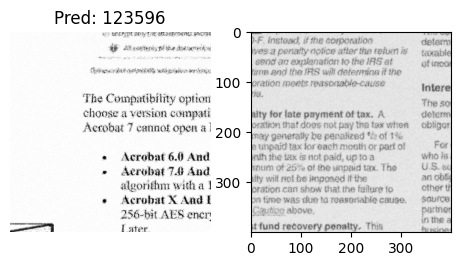

In [28]:
def visualize_model_predictions(model_path, X_val):
    model = tf.keras.models.load_model(model_path)
    predictions = model.predict(X_val)

    # Assuming you want to visualize the first 5 predictions
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_test[i].reshape(400, 400), cmap='gray')  # Adjust reshape based on your input shape
        plt.title(f"Pred: {np.argmax(predictions[i])}")  # Adjust according to your output
        plt.axis('off')
    plt.show()


# Y_test = model.predict(X_test[:4])
# Load and visualize the models
for epoch in range(6):  # Assuming you trained for 100 epochs
    model_path = f"{save_directory}/model_epoch_{epoch + 1}.weights.h5"
    visualize_model_predictions(model_path, X_test[:1])

## Next steps
- Training the model on a larger dataset
- Tuning parameters to achieve greater performance
- Fine-tuning the models on a different dataset to implement more functions (e.g., watermark removal and motion deblur)

In [89]:
import os
from PIL import Image
import numpy as np

def split_image(image):
    patches = []
    img_width, img_height = image.size  # (width, height)
    patch_width, patch_height = 400, 400  # (width, height)

    row_index = 0
    for top in range(0, img_height, patch_height):
        bottom = min(top + patch_height, img_height)
        col_index = 0
        for left in range(0, img_width, patch_width):
            right = min(left + patch_width, img_width)
            box = (left, top, right, bottom)
            patch = image.crop(box)
            patch_array = np.asarray(patch, dtype=np.float32)

            # Pad patch if it's smaller than patch size
            if patch_array.shape[0] < patch_height or patch_array.shape[1] < patch_width:
                padded_patch = np.zeros((patch_height, patch_width), dtype=np.float32)
                padded_patch[:patch_array.shape[0], :patch_array.shape[1]] = patch_array
                patch_array = padded_patch

            patches.append((patch_array, (row_index, col_index)))
            col_index += 1
        row_index += 1

    return patches

def reassemble_image(patches, original_size):
    patch_height, patch_width = patches[0][0].shape  # (height, width)

    max_row = max(position[0] for _, position in patches)
    max_col = max(position[1] for _, position in patches)

    reconstructed_height = (max_row + 1) * patch_height
    reconstructed_width = (max_col + 1) * patch_width

    reconstructed_image = np.zeros((reconstructed_height, reconstructed_width), dtype=np.float32)

    for patch, (row, col) in patches:
        reconstructed_image[row * patch_height: (row + 1) * patch_height,
                            col * patch_width: (col + 1) * patch_width] = patch

    # Crop the reconstructed image to the original size
    orig_width, orig_height = original_size  # (width, height)
    reconstructed_image = reconstructed_image[:orig_height, :orig_width]

    return reconstructed_image.astype(np.uint8)

# Create output directory if it doesn't exist
output_dir = path+'/images_denoised'
os.makedirs(output_dir, exist_ok=True)

# Path to the test_invoice folder
input_dir = path+'/images_test'

# Iterate over all image files in the folder
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        input_path = os.path.join(input_dir, filename)
        print(f"Processing {input_path}...")

        # Load the image
        image = Image.open(input_path).convert('L')  # Convert to grayscale if needed

        # Save original image size
        original_size = image.size  # (width, height)

        # Split the image into patches
        patches = split_image(image)

        # Process each patch (e.g., denoising)
        denoised_patches = []
        for patch_array, position in patches:
            # Prepare the patch for the model
            patch_input = patch_array.reshape(1, patch_array.shape[0], patch_array.shape[1], 1) / 255.0

            # Process the patch with your model
            denoised_patch = model.predict(patch_input)
            denoised_patch = denoised_patch.squeeze() * 255.0  # Denormalize

            # Ensure the denoised patch is the correct size
            denoised_patch = denoised_patch.astype(np.float32)
            denoised_patches.append((denoised_patch, position))

        # Reassemble the processed patches into an image
        reconstructed_image_array = reassemble_image(denoised_patches, original_size)

        # Convert the NumPy array back to a PIL image
        reconstructed_image = Image.fromarray(reconstructed_image_array)

        # Save the reconstructed image
        output_path = os.path.join(output_dir, f"denoised_{filename}")
        reconstructed_image.save(output_path)


Processing data//images_test/20240907_084630307_iOS.png...
1/1 [==============================] - 0s 63ms/step
Processing data//images_test/20240907_153544345_iOS.png...
1/1 [==============================] - 0s 64ms/step
Processing data//images_test/Einkauf_Manuel_2.png...
1/1 [==============================] - 0s 87ms/step
Processing data//images_test/20240907_084716938_iOS.png...
1/1 [==============================] - 0s 65ms/step
Processing data//images_test/Einkauf_Manuel_3.jpg...
1/1 [==============================] - 0s 75ms/step
Processing data//images_test/Einkauf_Manuel_1.png...
1/1 [==============================] - 0s 79ms/step
Processing data//images_test/20240907_084512267_iOS.png...
1/1 [==============================] - 0s 78ms/step
Processing data//images_test/Einkauf_Dhana_1.png...
1/1 [==============================] - 0s 79ms/step
Processing data//images_test/20240907_153544345_iOS 1.png...
1/1 [==============================] - 0s 66ms/step
Processing data//images_